<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:


- **TransactionID:** Identificador único alfanumérico para cada transacción.

- **AccountID:** Identificador único de la cuenta asociada a la transacción.

- **TransactionAmount:** Monto de la transacción.

- **TransactionDate:** Fecha y hora de la transacción.

- **TransactionType:** Tipo de transacción (Crédito o Débito).

- **Location:** Ubicación geográfica donde ocurrió la transacción.

- **DeviceID:** Identificador del dispositivo usado para la transacción.

- **IP Address:** Dirección IP asociada a la transacción, que puede cambiar ocasionalmente para algunas cuentas.

- **MerchantID:** Identificador único para los comercios, mostrando tanto comerciantes preferidos como atípicos para cada cuenta.

- **AccountBalance:** Saldo restante en la cuenta después de la transacción.

- **PreviousTransactionDate:** Fecha y hora de la transacción anterior en la cuenta.

- **Channel:** Canal utilizado para realizar la transacción (en línea, sucursal, cajero automático, etc.).

- **CustomerAge:** Edad del titular de la cuenta.

- **CustomerOccupation:** Ocupación del titular de la cuenta (por ejemplo, Doctor, Ingeniero, Estudiante, Jubilado), reflejando patrones de ingresos.

- **TransactionDuration:** Duración de la transacción en segundos.

- **LoginAttempts:** Número de intentos de inicio de sesión antes de realizar la transacción.

- **TransactionStatus:** Variable objetivo que indica si la transacción es "Normal" o "Anómala".


In [51]:
# !pip install plotly_express==0.4.0
# !pip install pyod

In [ ]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Ignoramos los warnings
# -----------------------------------------------------------------------
import warnings
warnings.simplefilter("ignore", FutureWarning)

import sys
sys.path.append("../../")
from src import soporte_visualizacion as sv
from src import soporte_enconding as se
from src import soporte_desbalanceo as sd
from src import soporte_outliers as so

# SKlearn
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Se utiliza para el iterative
# -----------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import chi2_contingency

In [53]:
df = pd.read_csv("datos/financial_data.csv")
df.head()

df.drop(columns=["transaction_time", "transaction_description"], inplace=True)

In [54]:
sv.Visualizador(df).exploracion_datos()

El número de filas es 10000 y el número de columnas es 9

----------

En este conjunto de datos tenemos 0 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


Series([], dtype: float64)


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
transaction_id,10000.0,5000.500000,2886.895680,1.00,2500.750,5000.500,7500.2500,10000.00
customer_id,10000.0,1051.272300,28.864062,1001.00,1026.000,1052.000,1076.0000,1100.00
merchant_id,10000.0,2050.486600,28.877801,2001.00,2025.000,2050.000,2076.0000,2100.00
amount,10000.0,4958.381617,2899.699675,10.61,2438.175,4943.945,7499.3125,9999.75
is_fraudulent,10000.0,0.506800,0.499979,0.00,0.000,1.000,1.0000,1.00
customer_age,10000.0,44.047500,15.321707,18.00,31.000,44.000,57.0000,70.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
card_type,10000,4,Discover,2633
location,10000,50,City-7,223
purchase_category,10000,6,Travel,1694



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     10000 non-null  int64  
 1   customer_id        10000 non-null  int64  
 2   merchant_id        10000 non-null  int64  
 3   amount             10000 non-null  float64
 4   is_fraudulent      10000 non-null  int64  
 5   card_type          10000 non-null  object 
 6   location           10000 non-null  object 
 7   purchase_category  10000 non-null  object 
 8   customer_age       10000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 703.3+ KB


None

In [55]:
# pd.to_datetime(df["transaction_time"]).dt.year.unique()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     10000 non-null  int64  
 1   customer_id        10000 non-null  int64  
 2   merchant_id        10000 non-null  int64  
 3   amount             10000 non-null  float64
 4   is_fraudulent      10000 non-null  int64  
 5   card_type          10000 non-null  object 
 6   location           10000 non-null  object 
 7   purchase_category  10000 non-null  object 
 8   customer_age       10000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 703.3+ KB


In [57]:
df.duplicated().sum()

np.int64(0)

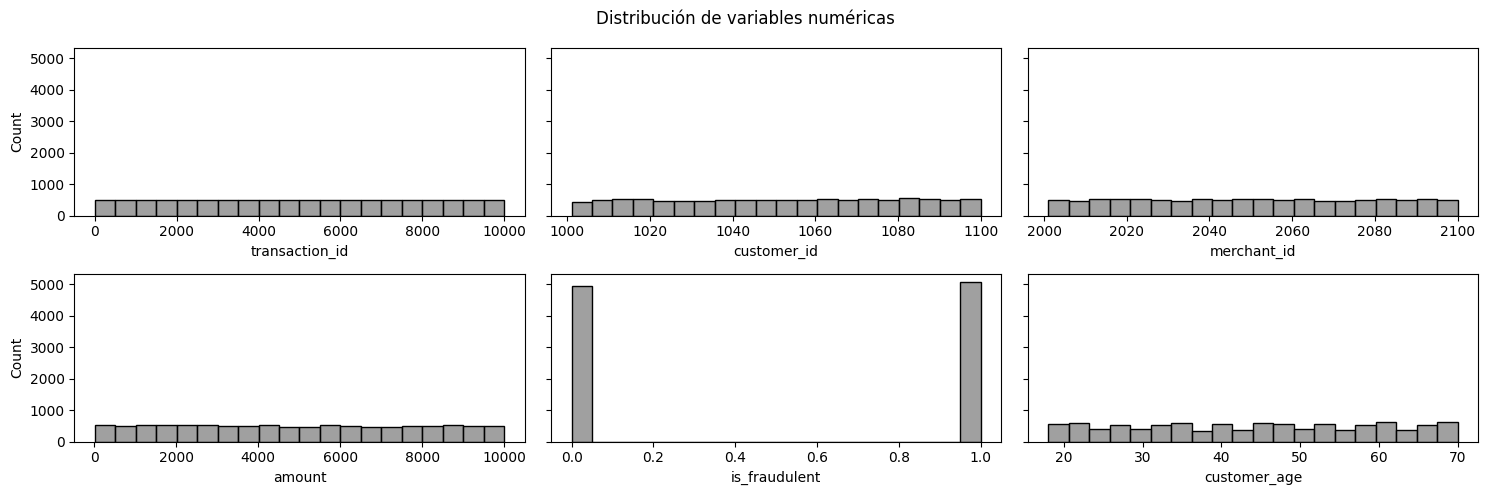

In [58]:
visualizador = sv.Visualizador(df)
visualizador.plot_numericas()

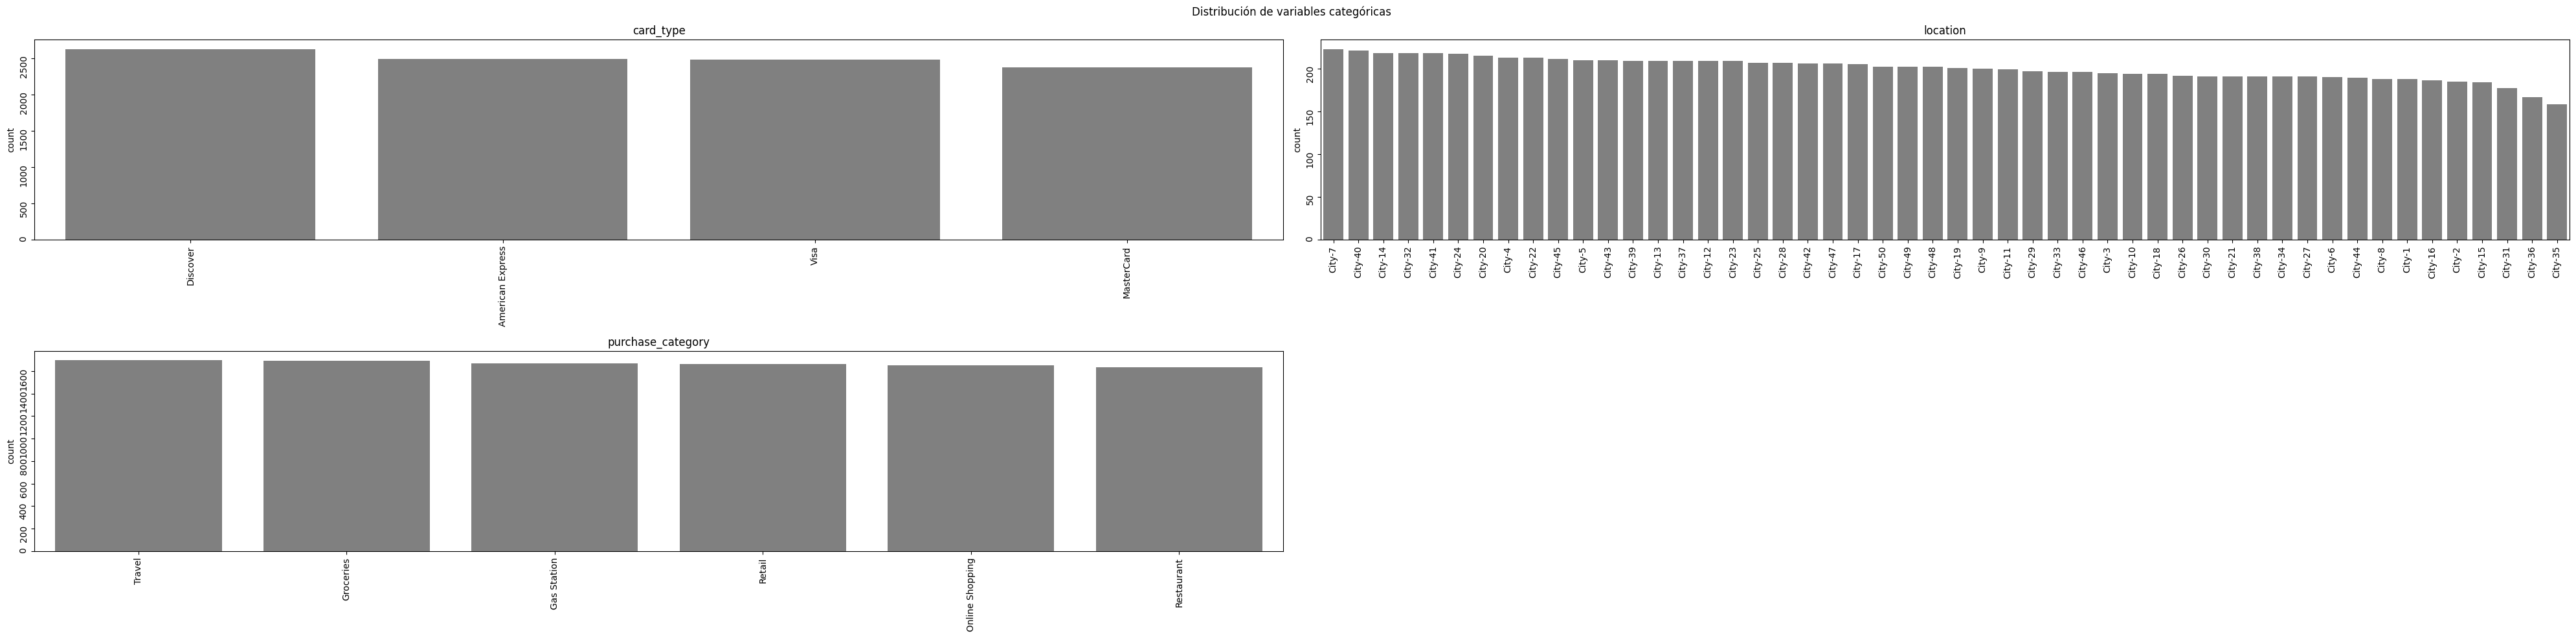

In [59]:
visualizador.plot_categoricas()

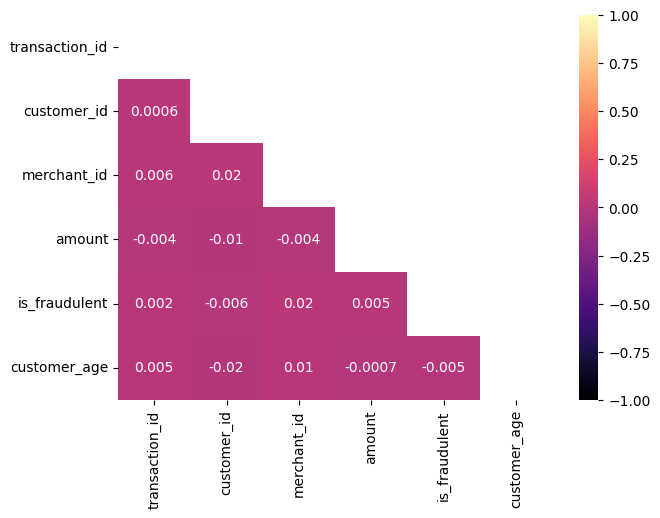

In [60]:
visualizador.correlacion()

- Tiene una distribución uniforme.
- No hay nulos, no hay duplicados.

In [61]:
def detectar_orden_cat(lista_categoricas, var_res):
    for categorica in lista_categoricas:
        print(f"Estamos evaluando la variable: {categorica.upper()}")
        df_cross_tab_gender = pd.crosstab(df[categorica], df[var_res])
        display(df_cross_tab_gender)

        chi2, p, dof, expected = chi2_contingency(df_cross_tab_gender)

        if p < 0.05:
            print(f"La variable categorica {categorica.upper()} si tiene orden\n")
        else:
            print(f"La variable categorica {categorica.upper()} no tiene orden\n")

detectar_orden_cat(df.select_dtypes(["object", "category"]), "is_fraudulent")

Estamos evaluando la variable: CARD_TYPE


is_fraudulent,0,1
card_type,,
American Express,1262,1232
Discover,1304,1329
MasterCard,1140,1243
Visa,1226,1264


La variable categorica CARD_TYPE no tiene orden

Estamos evaluando la variable: LOCATION


is_fraudulent,0,1
location,,
City-1,80,108
City-10,100,94
City-11,92,107
City-12,102,107
City-13,99,110
City-14,106,112
City-15,96,88
City-16,92,94
City-17,109,96


La variable categorica LOCATION no tiene orden

Estamos evaluando la variable: PURCHASE_CATEGORY


is_fraudulent,0,1
purchase_category,,
Gas Station,792,874
Groceries,796,896
Online Shopping,847,804
Restaurant,851,785
Retail,808,853
Travel,838,856


La variable categorica PURCHASE_CATEGORY si tiene orden



In [62]:
def detectar_orden_cat(lista_categoricas, var_res):
    lista_ordenas = []
    lista_desordenadas = []
    for categorica in lista_categoricas:
        print(f"Estamos evaluando la variable: {categorica.upper()}")
        df_cross_tab_gender = pd.crosstab(df[categorica], df[var_res])
        display(df_cross_tab_gender)

        chi2, p, dof, expected = chi2_contingency(df_cross_tab_gender)

        if p < 0.05:
            print(f"La variable categorica {categorica.upper()} si tiene orden\n")
            lista_ordenas.append(categorica)
        else:
            print(f"La variable categorica {categorica.upper()} no tiene orden\n")
            lista_desordenadas.append(categorica)

    return lista_ordenas, lista_desordenadas

In [ ]:
lista_ordenadas, lista_desordenadas = detectar_orden_cat(df.select_dtypes(["object", "category"]), "is_fraudulent")
diccionario_encoding = {"target": lista_ordenadas,
                        "onehot": lista_desordenadas}

print(lista_ordenadas)
print(lista_desordenadas)
# En caso de que queramos aplicar el método solo a una columna
encoding = se.Encoding(df, variable_respuesta="is_fraudulent", diccionario_encoding=diccionario_encoding)
df_oh = encoding.one_hot_encoding()
display(df_oh.head())
# df_target = se.Encoding(df_oh, "is_fraudulent", diccionario_encoding).target_encoding()
df_target = encoding.ordinal_encoding()
df_target.head()

Estamos evaluando la variable: CARD_TYPE


is_fraudulent,0,1
card_type,,
American Express,1262,1232
Discover,1304,1329
MasterCard,1140,1243
Visa,1226,1264


La variable categorica CARD_TYPE no tiene orden

Estamos evaluando la variable: LOCATION


is_fraudulent,0,1
location,,
City-1,80,108
City-10,100,94
City-11,92,107
City-12,102,107
City-13,99,110
City-14,106,112
City-15,96,88
City-16,92,94
City-17,109,96


La variable categorica LOCATION no tiene orden

Estamos evaluando la variable: PURCHASE_CATEGORY


is_fraudulent,0,1
purchase_category,,
Gas Station,792,874
Groceries,796,896
Online Shopping,847,804
Restaurant,851,785
Retail,808,853
Travel,838,856


La variable categorica PURCHASE_CATEGORY si tiene orden

['purchase_category']
['card_type', 'location']


,transaction_id,customer_id,merchant_id,amount,is_fraudulent,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9
0,1,1082,2027,5758.59,0,Gas Station,43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1015,2053,1901.56,1,Online Shopping,61,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1004,2035,1248.86,1,Gas Station,57,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,1095,2037,7619.05,1,Travel,59,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5,1036,2083,1890.10,1,Retail,36,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,transaction_id,customer_id,merchant_id,amount,is_fraudulent,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9
0,1,1082,2027,5758.59,0,0.524610,43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1015,2053,1901.56,1,0.486978,61,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1004,2035,1248.86,1,0.524610,57,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,1095,2037,7619.05,1,0.505313,59,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5,1036,2083,1890.10,1,0.513546,36,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Variable respuesta/objetivo is_fraudulent
# Si en el chi2 si no hay diferencias One Hot, si hay Target

In [65]:
# Outliers
outliers_uni = so.GestionOutliersUnivariados(df_target)
outliers_uni.detectar_outliers_z_score

<bound method GestionOutliersUnivariados.detectar_outliers_z_score of <src.soporte_outliers.GestionOutliersUnivariados object at 0x000001E7BD512810>>

In [66]:
from itertools import product

from tqdm import tqdm

outliers_multi = so.GestionOutliersMultivariados(df)
lista_neighbors = [20, 35, 50]
lista_contaminaciones =  [0.01, 0.05, 0.1]

combinaciones = list(product(lista_contaminaciones, lista_neighbors))
#df_prueba = df_target.copy()
for cont, vec in tqdm(combinaciones):
    df_temp = outliers_multi.detectar_outliers_lof(vec, cont)
    df_target = pd.concat([df_target, df_temp[df_temp.columns[-1]]], axis=1)

100%|██████████| 9/9 [00:01<00:00,  9.00it/s]


In [67]:
df_target.head()

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9,outlier_lof_20_0.01,outlier_lof_35_0.01,outlier_lof_50_0.01,outlier_lof_20_0.05,outlier_lof_35_0.05,outlier_lof_50_0.05,outlier_lof_20_0.1,outlier_lof_35_0.1,outlier_lof_50_0.1
0,1,1082,2027,5758.59,0,0.524610,43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2,1015,2053,1901.56,1,0.486978,61,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,1,1,-1,-1,-1,-1,-1,-1
2,3,1004,2035,1248.86,1,0.524610,57,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,4,1095,2037,7619.05,1,0.505313,59,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,1,-1,-1,-1,-1,-1
4,5,1036,2083,1890.10,1,0.513546,36,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,-1,-1,-1,-1,-1,-1


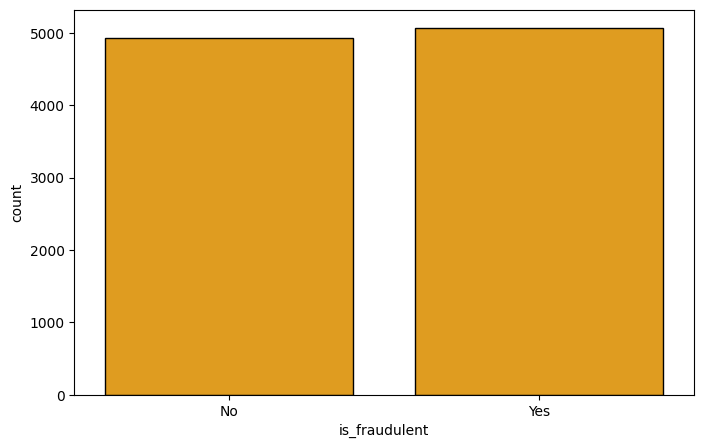

In [68]:
desbalanceo = sd.Desbalanceo(df_target, "is_fraudulent")
desbalanceo.visualizar_clase()

In [69]:
# No hay desbalanceo

In [70]:
columnas_outliers = df_target.filter(like="outlier").columns
df_target.drop(columns=columnas_outliers, inplace=True)

In [71]:
df_target.isna().sum()

transaction_id      0
customer_id         0
merchant_id         0
amount              0
is_fraudulent       0
                   ..
location_City-50    0
location_City-6     0
location_City-7     0
location_City-8     0
location_City-9     0
Length: 61, dtype: int64

In [72]:
df_target.to_pickle("datos/financial_data_target.pkl")